In [ ]:
# เช็กว่า GPU พร้อมใช้
!nvidia-smi


!pip install gradio

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os


Wed Jun 11 04:12:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!rm -rf /content/drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import shutil
import random

# Path ปัจจุบัน
source_dir = '/content/drive/MyDrive/RecyclableWasteDataset/datasetforfinal'

#แบ่งข้อมูลเป็น train และ test ในโฟลเดอร์ใหม่
base_output_dir = '/content/drive/MyDrive/RecyclableWasteDataset/splitdatasetforfinal'
train_dir = os.path.join(base_output_dir, 'train')
test_dir = os.path.join(base_output_dir, 'test')


train_split = 0.8

def split_dataset():
    if not os.path.exists(train_dir): os.makedirs(train_dir)
    if not os.path.exists(test_dir): os.makedirs(test_dir)

    for class_name in sorted(os.listdir(source_dir)):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        train_count = int(len(images) * train_split)

        train_images = images[:train_count]
        test_images = images[train_count:]


        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

        print(f"{class_name}: {len(train_images)} train | {len(test_images)} test")


split_dataset()


glass: 1560 train | 391 test
metal: 1459 train | 365 test
paper: 1872 train | 469 test
plastic: 1532 train | 383 test


In [ ]:
import os
#เช็คภาพ test แต่ละคลาส
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        print(f"{class_name}: {num_images} images")


glass: 391 images
metal: 365 images
paper: 469 images
plastic: 383 images


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 5140 images belonging to 4 classes.
Found 1283 images belonging to 4 classes.
Found 1608 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = train_generator.num_classes

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 104s 607ms/step - accuracy: 0.3221 - loss: 1.5371 - val_accuracy: 0.3718 - val_loss: 1.3636
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 94s 583ms/step - accuracy: 0.4420 - loss: 1.2519 - val_accuracy: 0.4263 - val_loss: 1.2781
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 93s 579ms/step - accuracy: 0.5052 - loss: 1.1601 - val_accuracy: 0.4147 - val_loss: 1.2637
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 93s 578ms/step - accuracy: 0.5299 - loss: 1.1122 - val_accuracy: 0.4778 - val_loss: 1.2033
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 91s 567ms/step - accuracy: 0.5677 - loss: 1.0373 - val_accuracy: 0.5136 - val_loss: 1.1438
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 91s 564ms/step - accuracy: 0.5875 - loss: 1.0063 - val_accuracy: 0.4599 - val_loss: 1.1763
Epoch 7/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 91s 564ms/step - accuracy: 0.5891 - loss: 0.9934 - val_accuracy: 0.5612 - val_loss: 1.0692
Epoch 8/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 91s 563ms/step - accuracy: 0.6277 - loss: 

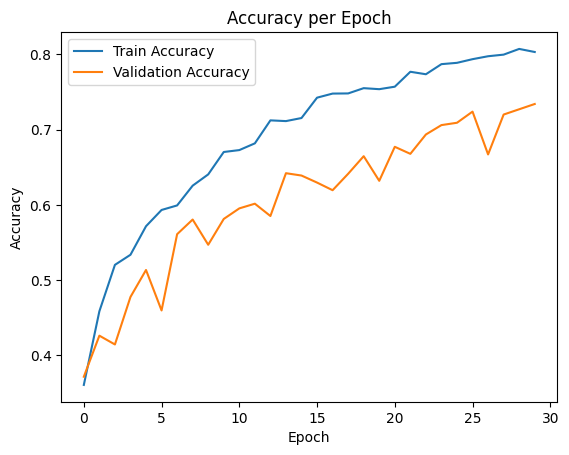

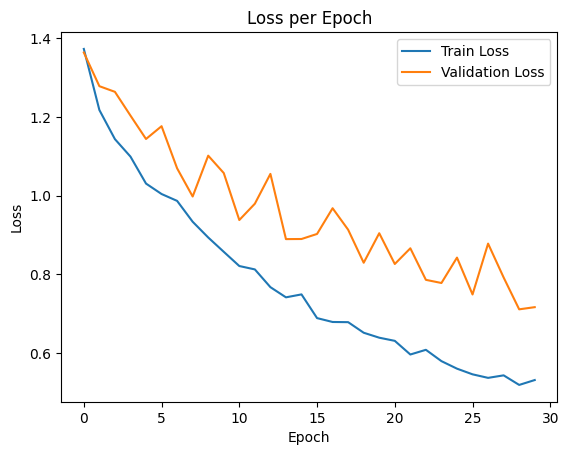

In [ ]:
import matplotlib.pyplot as plt

# กราฟaccuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()

# กราฟloss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")


51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.7343 - loss: 0.7572
Test Accuracy: 0.82
Test Loss: 0.58


In [ ]:
from sklearn.metrics import classification_report
import numpy as np


y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes


class_labels = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step
              precision    recall  f1-score   support

       glass       0.86      0.68      0.76       391
       metal       0.83      0.80      0.82       365
       paper       0.86      0.90      0.88       469
     plastic       0.74      0.87      0.80       383

    accuracy                           0.82      1608
   macro avg       0.82      0.81      0.81      1608
weighted avg       0.82      0.82      0.82      1608



<Figure size 800x600 with 0 Axes>

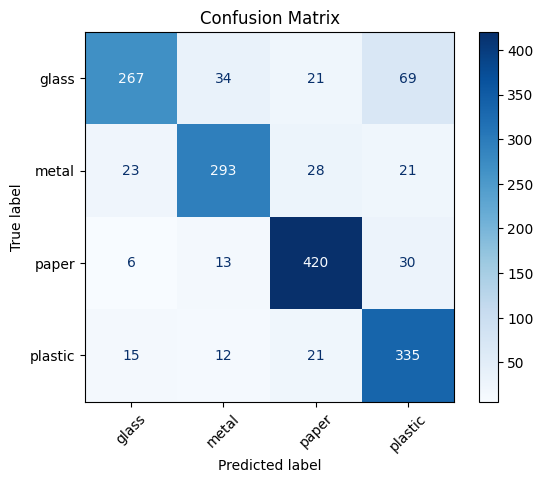

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# เซฟโมเดลแบบลงไดร์ฟ
model.save('/content/drive/MyDrive/RecyclableWasteDataset/model.h5')


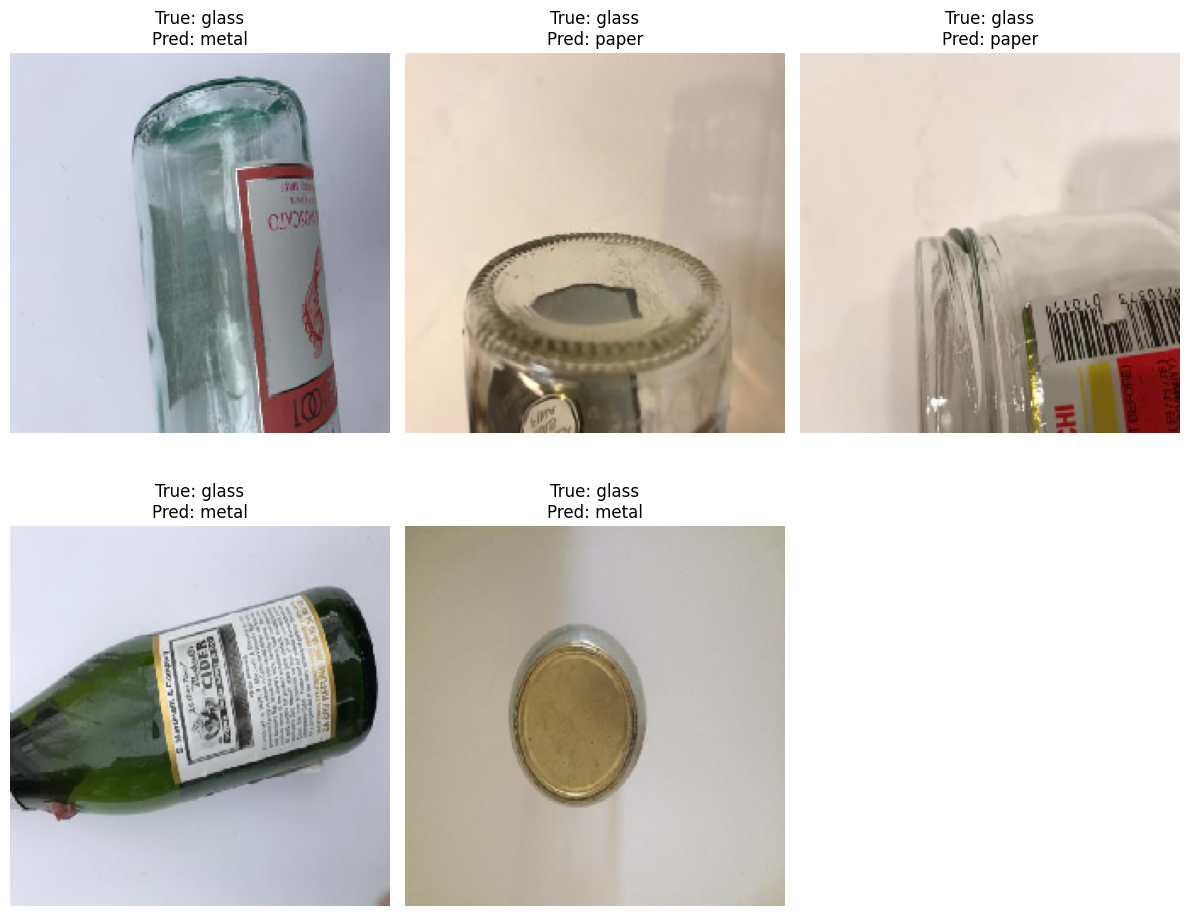

In [ ]:
import matplotlib.pyplot as plt


filenames = test_generator.filenames
misclassified_idx = np.where(y_pred_classes != y_true)[0]

# แสดงภาพผิด
plt.figure(figsize=(12, 10))
for i, idx in enumerate(misclassified_idx[:5]):
    img_path = os.path.join(test_dir, filenames[idx])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {class_labels[y_true[idx]]}\nPred: {class_labels[y_pred_classes[idx]]}")
plt.tight_layout()
plt.show()



ภาพที่ทำนายผิดคลาส: glass (124 รูป)


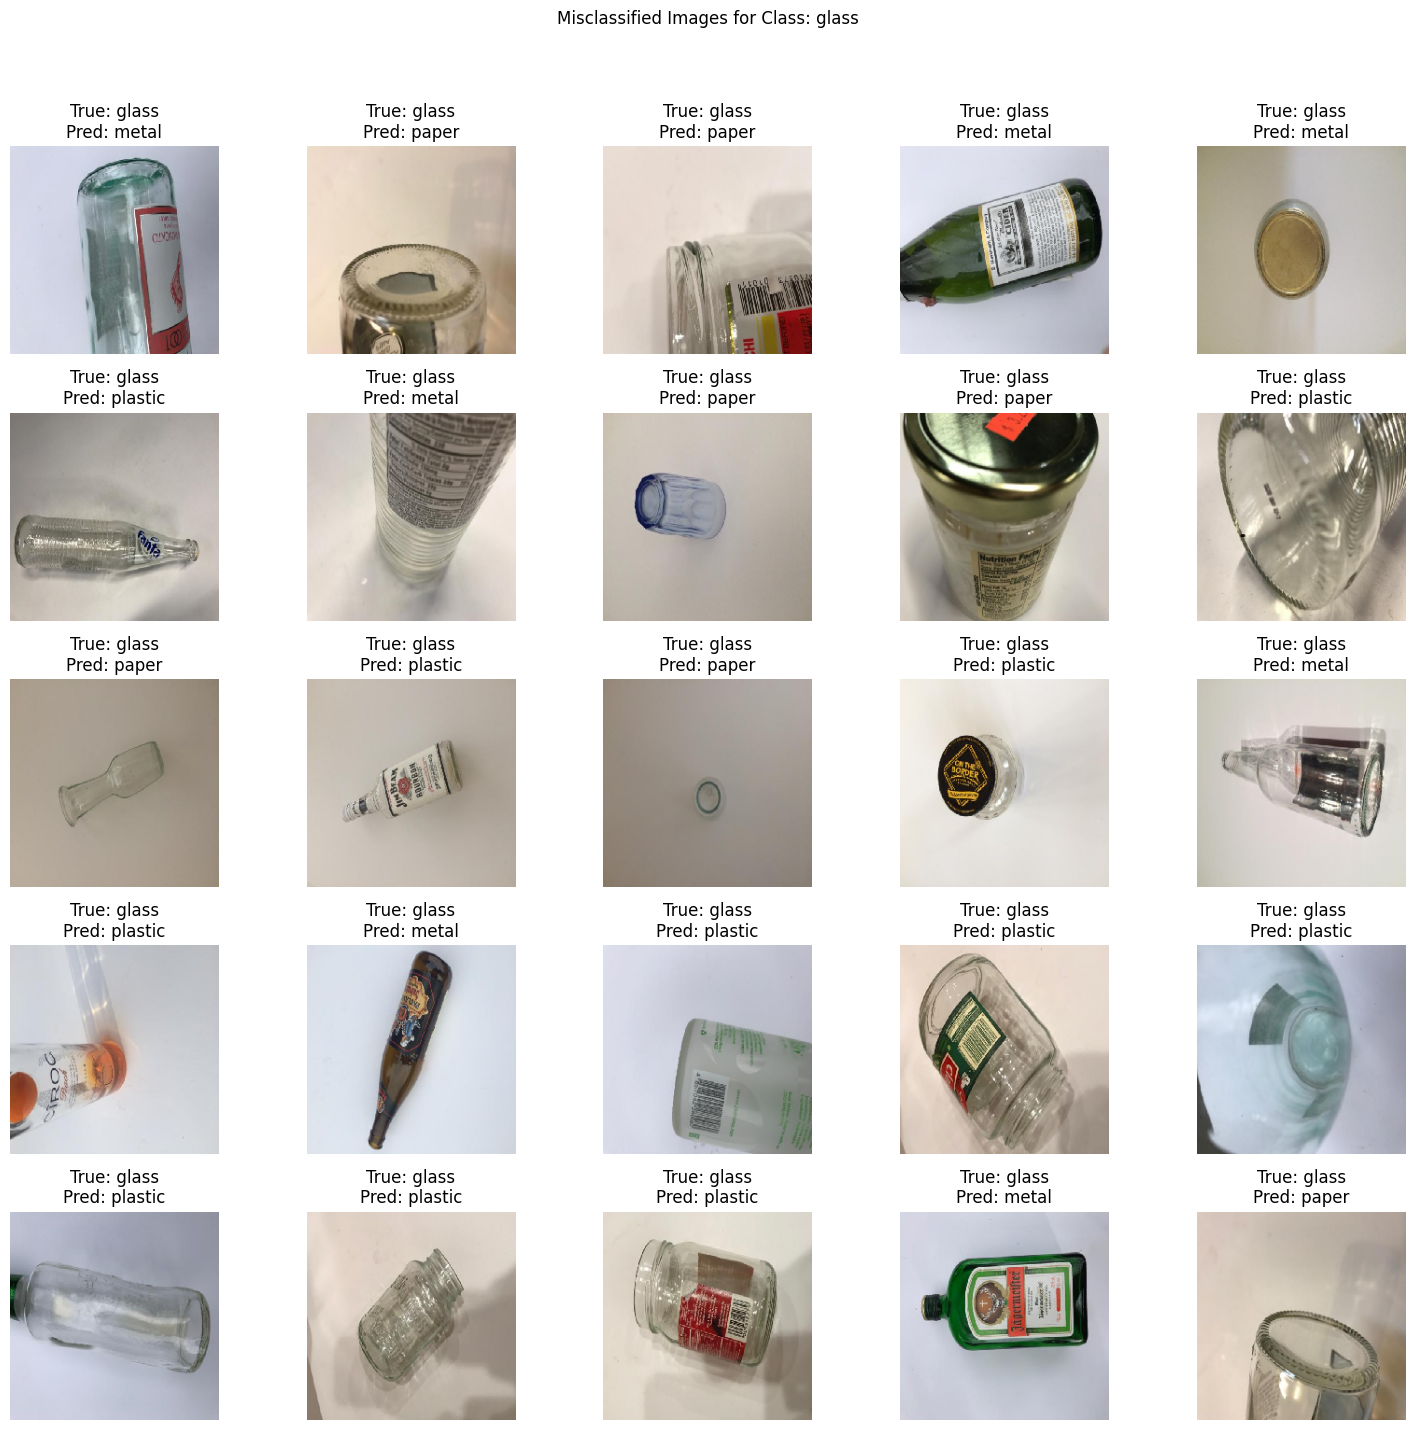


ภาพที่ทำนายผิดคลาส: metal (72 รูป)


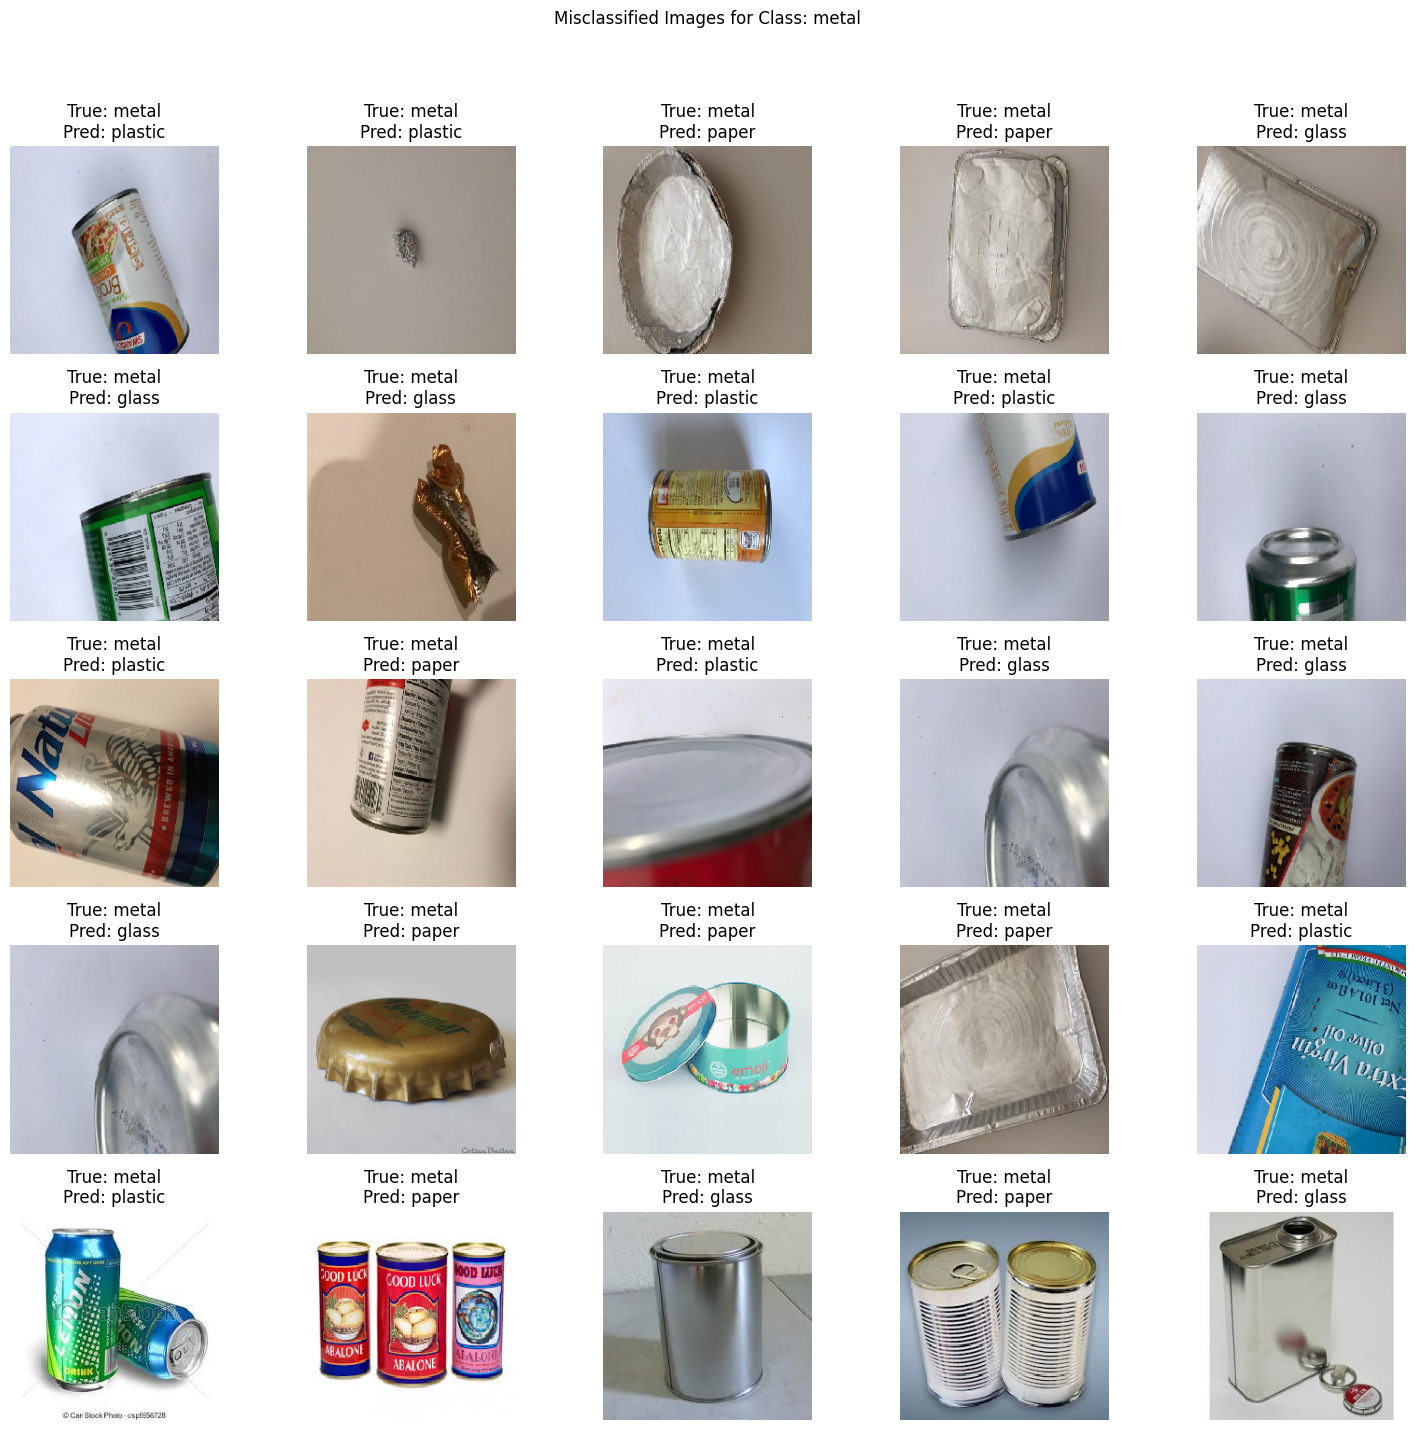


ภาพที่ทำนายผิดคลาส: paper (49 รูป)


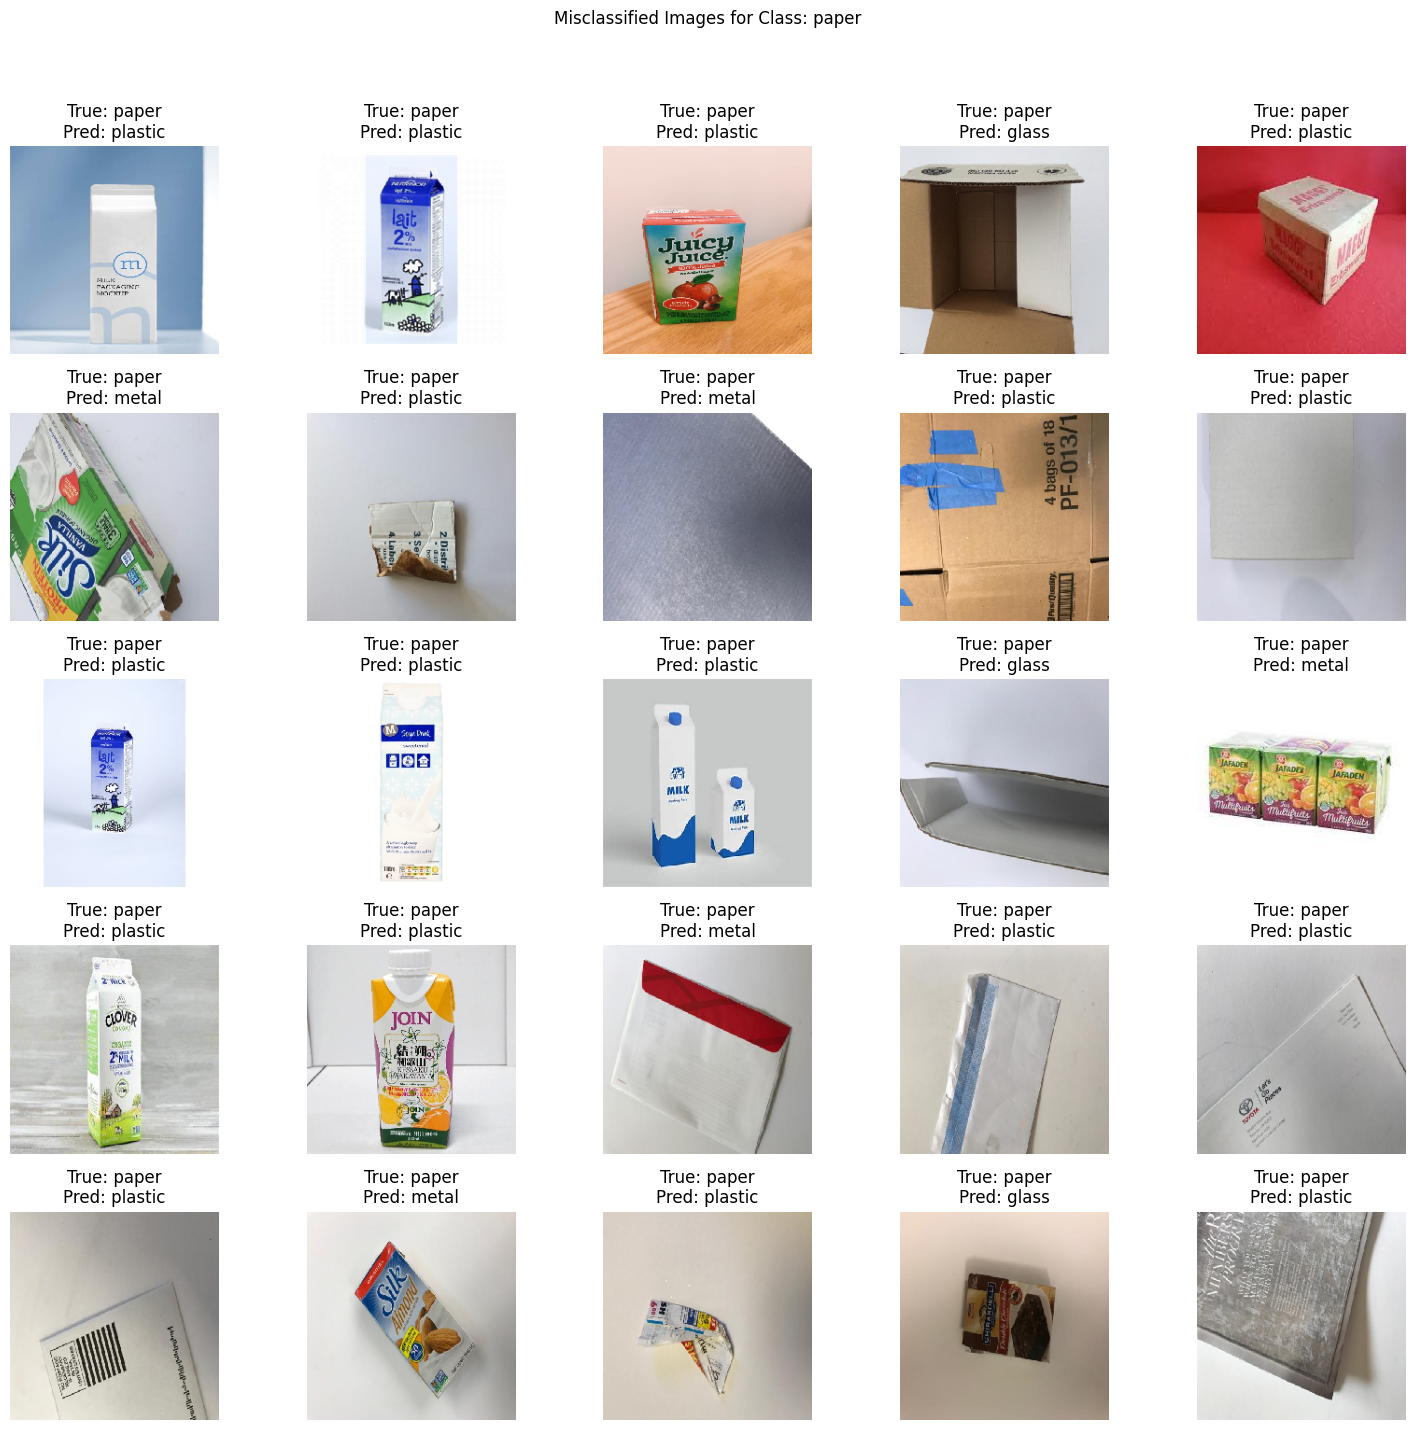


ภาพที่ทำนายผิดคลาส: plastic (48 รูป)


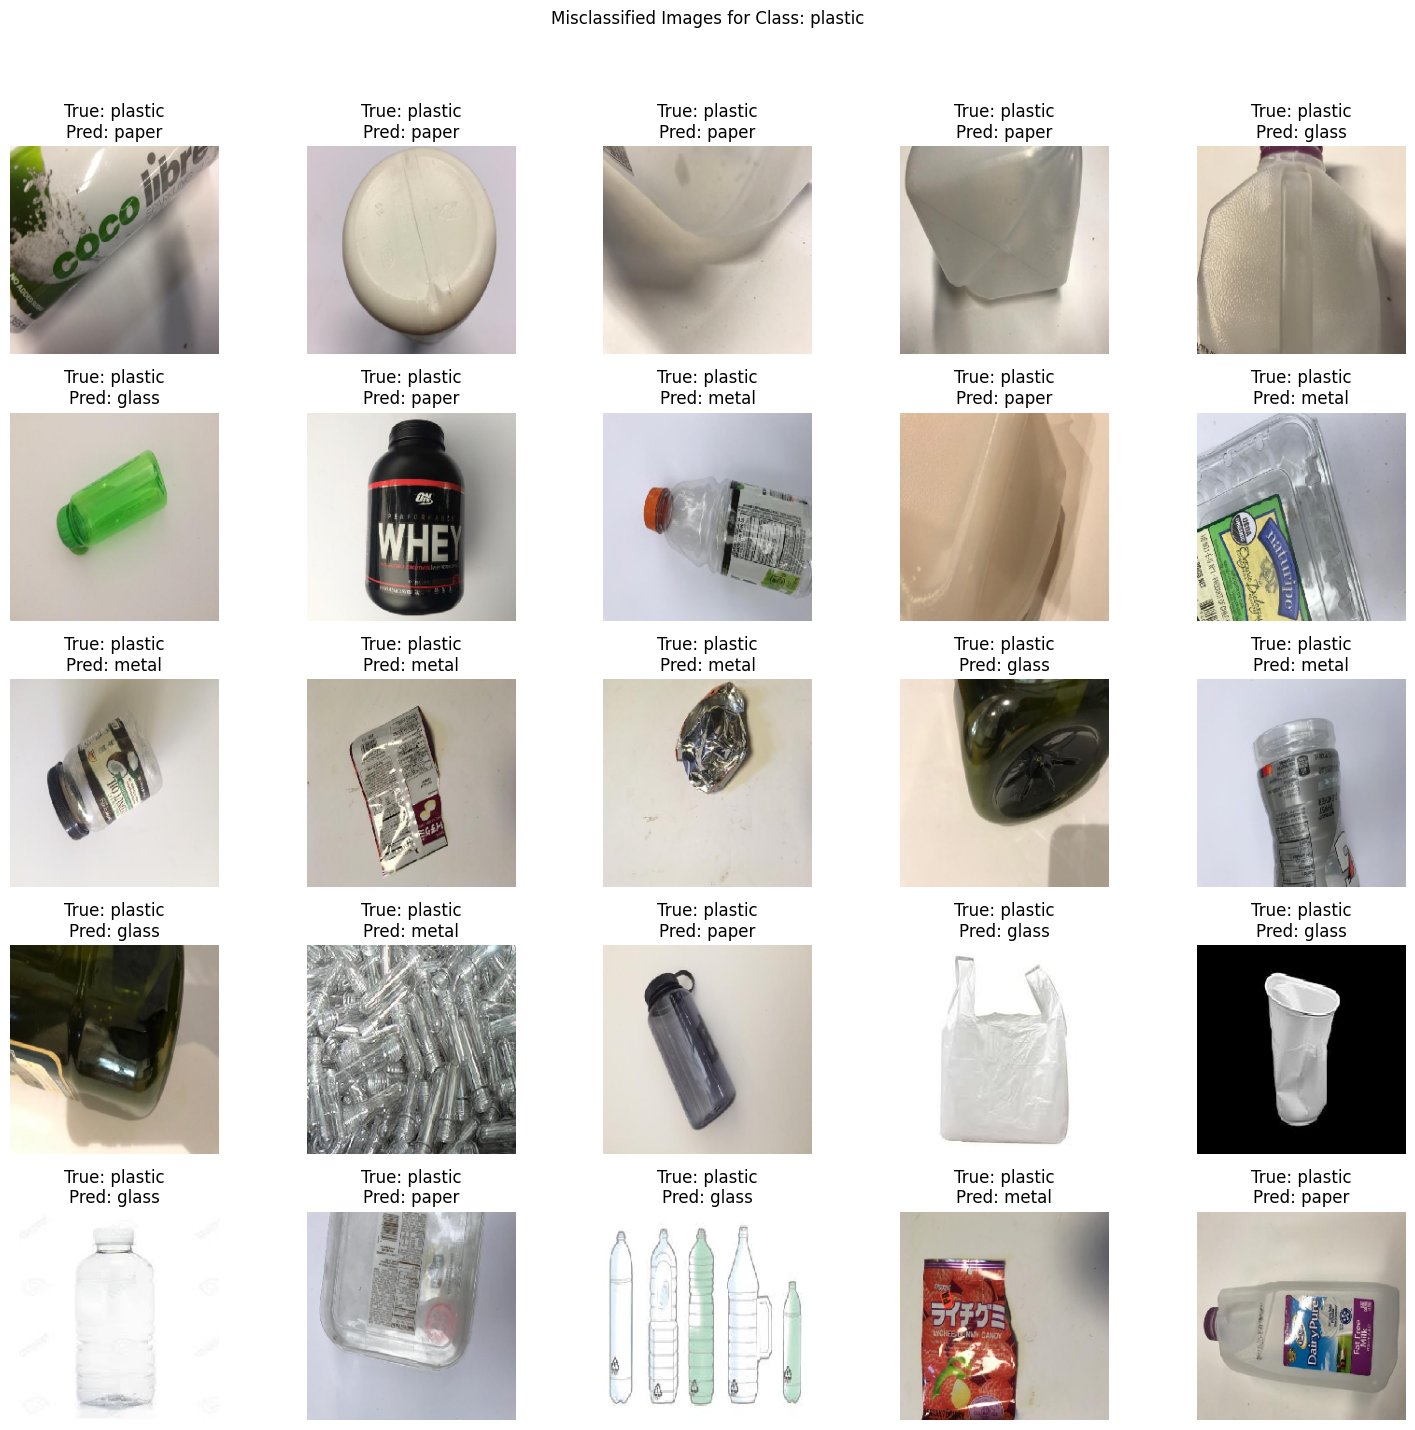

In [ ]:
#ดูภาพที่ทำนายผิดทุกคลาส

# Function to display misclassified images for a specific class
def display_misclassified_for_class(true_class_label):
    true_class_index = class_labels.index(true_class_label)
    misclassified_indices_for_class = [
        idx for idx in misclassified_idx
        if y_true[idx] == true_class_index
    ]

    print(f"\nภาพที่ทำนายผิดคลาส: {true_class_label} ({len(misclassified_indices_for_class)} รูป)")

    plt.figure(figsize=(15, 15))
    # Limit to showing at most 25 images per class to avoid overcrowding
    display_count = min(len(misclassified_indices_for_class), 25)

    for i, idx in enumerate(misclassified_indices_for_class[:display_count]):
        img_path = os.path.join(test_dir, filenames[idx])
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {class_labels[y_true[idx]]}\nPred: {class_labels[y_pred_classes[idx]]}")

    if display_count > 0:
        plt.suptitle(f"Misclassified Images for Class: {true_class_label}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()
    else:
        print(f"ไม่พบภาพที่ทำนายผิดคลาส {true_class_label}")


# Loop through all classes and display misclassified images for each
for class_label in class_labels:
    display_misclassified_for_class(class_label)